# TERCER NOTEBOOK - KMEANS COMO MÉTODO DE CLUSTERING PARA LA COLUMNA DE OBSERVACIONES

**Contenido**

1. Diseño del algoritmo 
2. Resultados ELBOW para encontrar el número óptimo de clusters
3. Ejecución del algoritmo Kmeans 
4. Gráfica de la cantidad de ordenes de trabajo (OT) por cluster encontrado

El objetivo de este tercer notebook es el diseño e implementación de un algoritmo basado en las distancias entre cada oración en la columna de observaciones, con el fin de agrupar (clustering) las oraciones con similar contenido y poder identificar patrones de comportamiento. 

# I. DISEÑO DEL ALGORITMO

#### Importar paquetes 

In [1]:
import collections
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from pprint import pprint
import numpy as np
from string import punctuation
from time import time
import os
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt

# Stop Words
with open('../spanish4.0.txt','r') as f:
    stop_words = f.read().splitlines()

#### Estructura del algoritmo

In [2]:
# Tokenizar palabras
def word_tokenizer(text):    
    tokens = word_tokenize(text)   # tokenizes and stems the text
    # non_words = list(punctuation)  # removes punctuation 
    # text = ''.join([c for c in text if c not in non_words]) ---> Data ingresada ya está libre de puntuación
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words] # Posibilidad de extender stopwords
    return tokens

In [3]:
# Número óptimo de clústers
def elbow_method(sentences,figsize = (8,5),  namecol=None, nro_top=None, save = False,width_text = 0.83, height_text = 0.92):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,lowercase=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)   #builds a tf-idf matrix for the sentences
    import warnings
    
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if len(sentences)<= 30:
                list_k = list(range(1,len(sentences)+1))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)

            elif len(sentences)> 30 and len(sentences)<= 70:
                list_k = list(range(2,len(sentences)+1,2))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)     

            else:     
                list_k = list(range(2,71,4))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)

            from kneed import KneeLocator
            kn = KneeLocator(list_k, elbow, curve='convex', direction='decreasing')
            print(f'Número óptimo de clústers: {kn.knee}')

            plt.rcParams.update({'figure.figsize':figsize})
            plt.xlabel('Número de clusters k')
            plt.ylabel('Suma de distancias cuadradas')
            plt.plot(list_k, elbow, 'bo-')
            plt.title('Método del Elbow')
            plt.text(width_text, height_text, f'k óptimo: {kn.knee}', transform=plt.gca().transAxes)
            plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
            if save :
                plt.savefig(f'{namecol} {nro_top} - Método del elbow.jpg', dpi= 200, quality=95)
            plt.show()

    except ValueError:
        print('You must enter at least two sentences')

In [4]:
# Algoritmo Kmeans
def cluster_sentences(sentences, nb_of_clusters):

    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,lowercase=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)   #builds a tf-idf matrix for the sentences
    
    kmeans = KMeans(n_clusters=nb_of_clusters,max_iter=300)
    #kmeans.fit(tfidf_matrix)
    X_dist=kmeans.fit_transform(tfidf_matrix)**2  #Se calcula la distancia del cluster y se multiplica al cuadrado
    clusters = collections.defaultdict(list)
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(i)

    Distancia=X_dist.sum(axis=1)  #Se calcula la distancia por columna de la matriz

    distDict={}  #Se traspasa a un diccionario con las distancias por cluster
    for key,val in clusters.items():
        distDict[key]=Distancia[val]

    representativos=[]   # Se guarda en una lista los valores mínimos de cada cluster (Menor distancia al centro mejor es el representativo)
    
    #Verificacion de los numeros de clusters
    #Si se intenta obtener los representativos de un número mas grande de cluster que el permitido, se procesa el número de clusters
    if len(distDict)<nb_of_clusters:
        nb_of_clusters=len(distDict)
        
    #Verificacion de los números de clústers
    for i in range(nb_of_clusters):
        representativos.append(np.where(distDict[i]==min(distDict[i]))[0][0])

    return dict(clusters),representativos

In [5]:
# Plot cantidad de sentences por cluster
def len_clusters(dic, n, namecol=None, nro_top=None, save = False, width = 0.6, color = "royalblue", figsize = (8,5)):
    keys = list(range(0,n))
    len_values = [len(dic[i]) for i in keys]
    plt.rcParams.update({'figure.figsize': figsize})
    plt.bar(keys,len_values , align='center', color = color, width = width)
    plt.title('Cantidad de OT por clúster')
    plt.xlabel('Clusters')
    plt.ylabel('Orden de Trabajo (OT)')
    plt.xticks(np.arange(min(keys), max(keys)+1, 1.0))
    if save:
        plt.savefig(f'{namecol} {nro_top} - Distribucion clusters .jpg', dpi= 200, quality=95)
    plt.show()

<div class="alert alert-success" style="margin: 20px">Para poder ejecutar correctamente los algoritmos de arribe, es necesario tener base de datos previamente limpia y en formato. Para más información ir al primer notebook, donde es aplicada la función word_cleaner().</div>

#### Importar Data Frame 

In [6]:
df_total = pd.read_pickle('../2. Topic Modeling - LDA 24 topics/BD_original_cleaned_TOPICO_DOMINANTE.pkl')
df_total.head()

Region                                           Estacion  \
0    13°                                       Tingaro Spa.   
1     8°                       Combustibles El Volcan Ltda.   
2    10°           LLANOS Y WAMMES SOCIEDAD COMERCIAL LTDA.   
3     1°     Soc. Imp. y Exp. Nuevo Amanecer Ltda. (SOCIEX)   
4     3°  Inmobiliaria e Inversiones San José Ltda (Vall...   

               Tipo de Falla Prioridad Cliente  Estado OT Tecnico Asignado  \
0  Carrete RetractilOTROOTRO   Normal 48 Horas    CERRADA      Juan Aliaga   
1  Carrete RetractilOTROOTRO   Normal (48 hrs)    CERRADA          On Line   
2  Carrete RetractilOTROOTRO   Normal 24 Horas  PRECIERRE   Luis Almonacid   
3  Carrete RetractilOTROOTRO   Normal (48 hrs)    CERRADA          On Line   
4  Carrete RetractilOTROOTRO   Normal (48 hrs)    CERRADA          On Line   

       Dia  Nro Dia     Mes  Hora Rango Recep/Arribo Rango Arribo/Cierre  \
0  Viernes       30  AGO 19    16    Error en fechas        Más de 1 mes   
1  Viernes       30  AGO 19    12    Error en fechas         Menos de 1h   
2  Viernes       30  AGO 19    12       0 a 24 horas         Menos de 1h   
3  Viernes       30  AGO 19    12       0 a 24 horas         Menos de 1h   
4  Viernes       30  AGO 19    12    Error en fechas         Menos de 1h   

                                         Observación  \
0  se cambia placa de tk 2 gas95 por placa que in...   
1  cambio de graficas de equipos no esta contempl...   
2  se visita eds para chequeo de dispensador el c...   
3  remplazo de graficas no esta contemplado en es...   
4  remplazo de graficas no esta contemplado en co...   

                                       Requerimiento  Topico Dominante  
0  area de atencion habilitar estanque de combust...                 2  
1  area de atencion combustible maria veronica go...                23  
2  area de atencion surtidor de diesel a ratos co...                 3  
3  area de atencion combustible cambiar graficas ...                 4  
4  area de atencion combustible solicita grafica ...                 4

# II. RESULTADOS DE KMEANS

## 1. TIPO DE FALLA

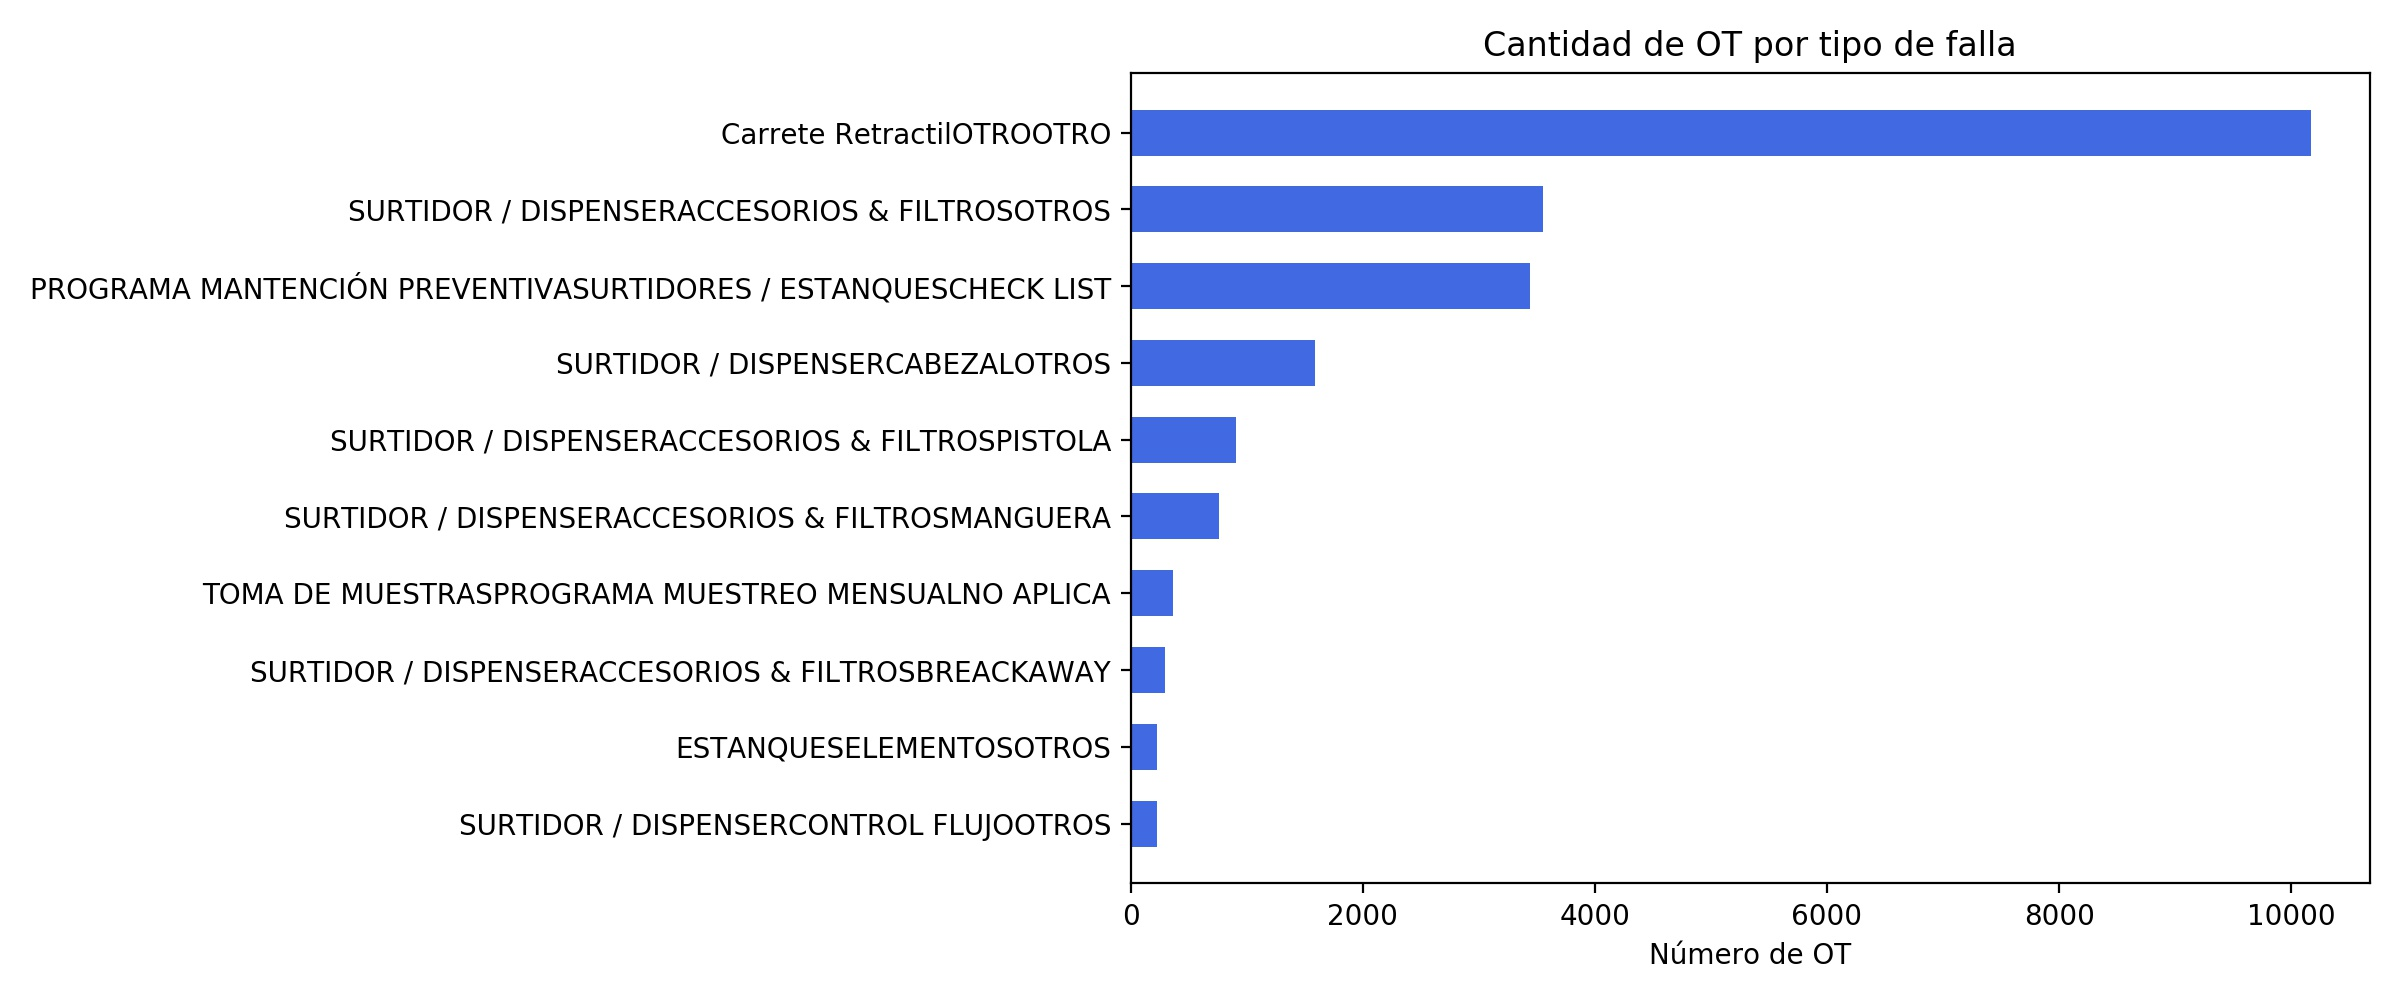

In [7]:
from IPython.display import Image
Image(filename='../1. OGC - Análisis y limpieza BD/3) Tipo de falla.jpg',width=800, height=600)

In [8]:
# SELECCIONANDO UN TIPO DE FALLA EN PARTICULAR ('SURTIDOR / DISPENSERCABEZALOTROS')
df = df_total[df_total['Tipo de Falla'] == 'SURTIDOR / DISPENSERCABEZALOTROS'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

1561

In [9]:
# Extracto obs tipo de falla
sentences[:2]

['se realiza el cambio de 1 motor monofasico 34 hp proporcionado por sercon quedando equipo operativo',
 'en dispensador 2 diesel se cambia orings de eje punta del medidor lo que mojaba el pulser y arrojaba error 2 0 se realizan pruebas y se verifica que no alla filtracion equipo queda 100 operativo ambas bocas en dispensador 2 diesel se cambia orings de eje punta del medidor lo que mojaba el pulser y arrojaba error 2 0 se realizan pruebas y se verifica que no alla filtracion equipo queda 100 operativo ambas bocas']

#### Ejecutar el algoritmo para un tipo de falla 

Número óptimo de clústers: 26


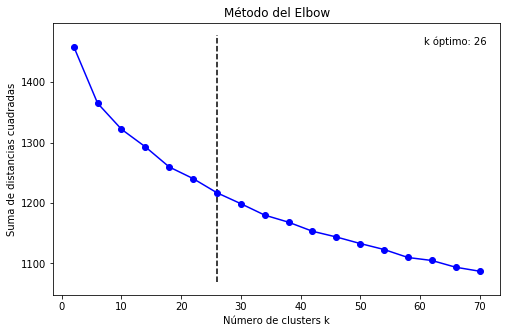

Wall time: 1min 1s


In [10]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

In [11]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=26
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : ot mal asignada por cliente
	sentence  0 :  ods mal emitido
	sentence  1 :  ods mal emitida
	sentence  2 :  ods mal emitida
	sentence  3 :  ods mal ingresada
	sentence  4 :  ods reasignada por cliente a otro contratista
	sentence  5 :  mal ingresada
	sentence  6 :  ods mal ingresada
	sentence  7 :  mal ingresada
	sentence  8 :  mal ingresada
	sentence  9 :  ods reasignada por cliente
	sentence  10 :  ods reasignada por cliente
	sentence  11 :  ods mal ingresada
	sentence  12 :  ods mal asignada
	sentence  13 :  ods mal asignada
	sentence  14 :  ods mal asignada
	sentence  15 :  ods mal emitida
	sentence  16 :  ods mal emitida
	sentence  17 :  ods anulada por enex
	sentence  18 :  ods mal emitida
	sentence  19 :  la ods sera asignada a otro contratista
	sentence  20 :  ot mal asignada por cliente
	sentence  21 :  incidencia mal asignada
Cluster 1 : se realiza revision de equipos encontrandose despacho ok
	sentence  0 :  se realiza revison de equipo y tdf dtectando

	sentence  17 :  se chequea falla y se detecta problema de valvula proporcional danada se realizareparacion y cambio de kit oring seprueba quedando operativa 100 se realiza el cambio de ampolletas pls 9 watts quemadas queda 100 operativa eds se chequea falla y se detecta problema de valvula proporcional danada se realizareparacion y cambio de kit oring seprueba quedando operativa 100 se realiza el cambio de ampolletas pls 9 watts quemadas queda 100 operativa eds
	sentence  18 :  se realiza apoyo a adexus para cambio de ortirat a su vez en mismo pos es reemplazada 01 ampolleta pls p 13177 por estar quemada equipo queda operativo se realiza apoyo a adexus para cambio de ortirat a su vez en mismo pos es reemplazada 01 ampolleta pls p 13177 por estar quemada equipo queda operativo
	sentence  19 :  se revisa dispensador n 1 encontrando este con visor de precio y litros apagado se cambian 2 ampolletas 9w quedando operativo
	sentence  20 :  se reemplaza 1 ampolleta de 9watts la cual fue compr

	sentence  15 :  se realiza revision de flujo en boca 26 pd durante la realizacion de una venta esta arrojo una entrega de 32 ltrsm se procede a efectuar el cambio de 02 filtros de alta capacidad y se verifica flujo durante una venta registrandose una entrega de 88 ltrsm queda operativo se realiza revision de flujo en boca 26 pd durante la realizacion de una venta esta arrojo una entrega de 32 ltrsm se procede a efectuar el cambio de 02 filtros de alta capacidad y se verifica flujo durante una venta registrandose una entrega de 88 ltrsm queda operativo
	sentence  16 :  se realiza el cambio de 1 filtro alta capacidad quedando equipo operativo
	sentence  17 :  se realiza el cambio de 03 filtros de alta capacidad se verifica flujo en venta observando que en diesel despacha 24 lxm 97 32 lxm y 93 20 lxm se realiza cambio de filtros de alta capacidad en todos los productos a peticion de jefe de playa se realizan pruebas de flujo despachando diesel 97 y 93 32 lxm
	sentence  18 :  a solicitud 

	sentence  0 :  sw chequea problema y se detecta valvula de emergencia defectuosa se repara balvula y seprueba recirculando queda operativa en un 100 sw chequea problema y se detecta valvula de emergencia defectuosa se repara balvula y seprueba recirculando queda operativa en un 100
	sentence  1 :  se realiza revision a surtidor 3g2222 el cual se encuentra si energia electrica se chequea tablero y se observa automatico abajo se sube y automaticamente se vuelve a bajar se observa boton parada de emergencia activado se procede desactivar parada emergencia y se sube automatico surtidor enciende se hacen pruebas surtidor queda despachando de forma normal se realiza revision a surtidor 3g2222 el cual se encuentra si energia electrica se chequea tablero y se observa automatico abajo se sube y automaticamente se vuelve a bajar se observa boton parada de emergencia activado se procede desactivar parada emergencia y se sube automatico surtidor enciende se hacen pruebas surtidor queda despachand

In [12]:
# Clusters representativos (con n = 26)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : ot mal asignada por cliente
Cluster  1 : se realiza revision de equipos encontrandose despacho ok
Cluster  2 : se realiza el cambio de 1 manguera rv 1 pistola rv y 1 filtro baja capacidad quedando equipo operativo
Cluster  3 : se realiza el cambio de 1 correa de motor plus v queda pendiente el cambio de 1 sello brida surt 2 d se realizo remplazo de un sello brida de 1 p15024 quedo surt funcionando ok se realiza el cambio de 1 correa de motor plus v queda pendiente el cambio de 1 sello brida surt 2 d se realizo remplazo de un sello brida de 1 p15024 quedo surt funcionando ok
Cluster  4 : se realiza chequeo a surtidor no detectando filtraciones en equipo en estacion equipo operativo
Cluster  5 : se realiza revison de equipo encontrandose despacho venta cliente operativo
Cluster  6 : se realiza el cambio de 1 filtro spin on 1 filtro baja capacidad 1 valvula proporcional y 3 kit reparacion valvula proporcional quedando equipo operativo
Cluster  7 : se realiza el cambio de 2 pi

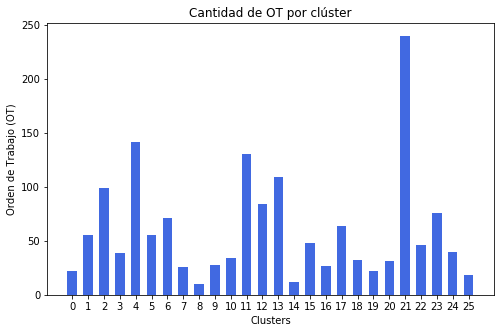

In [13]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = False) 

## 2. ESTACIONES

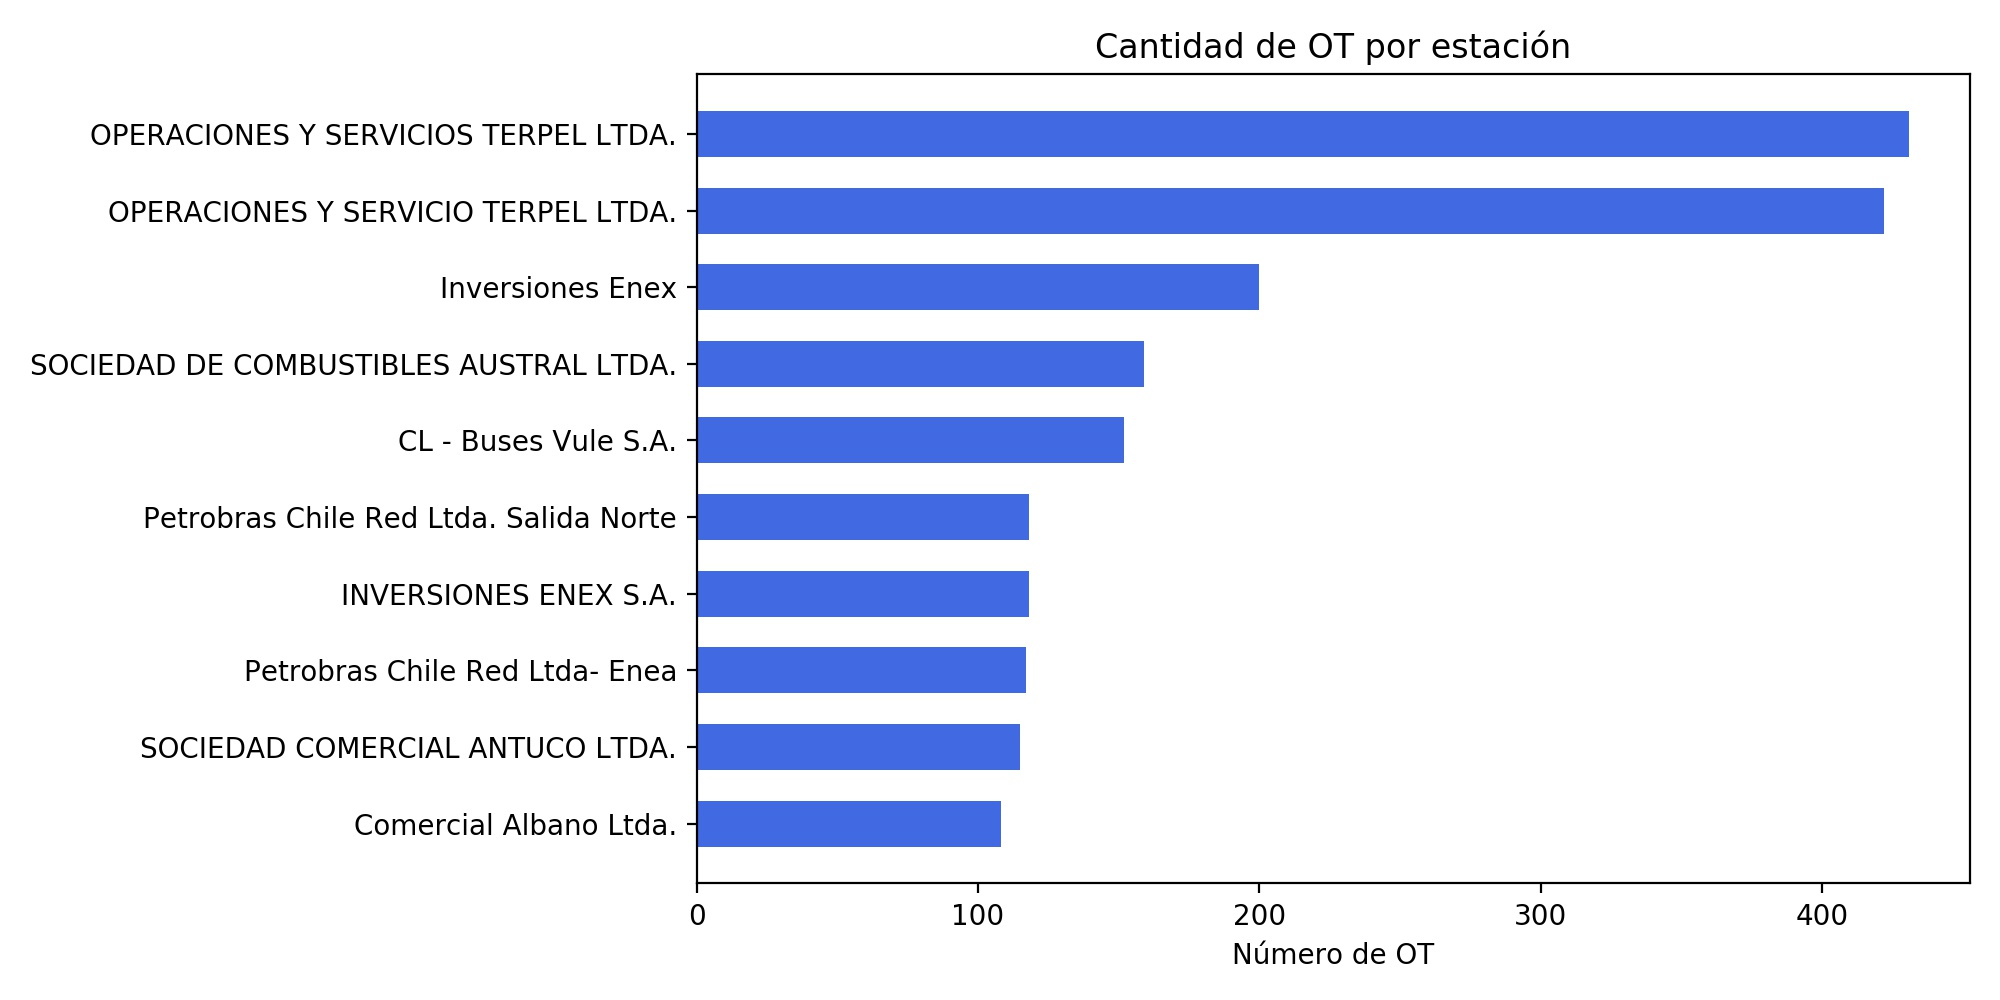

In [14]:
from IPython.display import Image
Image(filename='../1. OGC - Análisis y limpieza BD/2) Estacion.jpg',width=700, height=500)

In [15]:
# SELECCIONANDO UNA ESTACIÓN ('OPERACIONES Y SERVICIOS TERPEL LTDA.')
df = df_total[df_total['Estacion'] == 'OPERACIONES Y SERVICIOS TERPEL LTDA.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

416

In [16]:
# Extracto obs estacion
sentences[:2]

['se chequea falla y se detecta ortirak que cuando le da el sol directo se borra por completo esto no permite el corrrecto uso del mismo se informa y solicita reparacion a empresa encargada se chequea falla y se detecta ortirak que cuando le da el sol directo se borra por completo esto no permite el corrrecto uso del mismo se informa y solicita reparacion a empresa encargada se niega firma por no estar reparado don marcelo olate',
 'en dispensador numero 7 producto 93 se detecto union manguera pistola suelta y con filtracion se reapreta union manguera pistola quedando operativa en dispensador numero 7 producto 93 se detecto union manguera pistola suelta y con filtracion se reapreta union manguera pistola quedando operativa']

#### Ejecutar el algoritmo para una estación

Número óptimo de clústers: 14


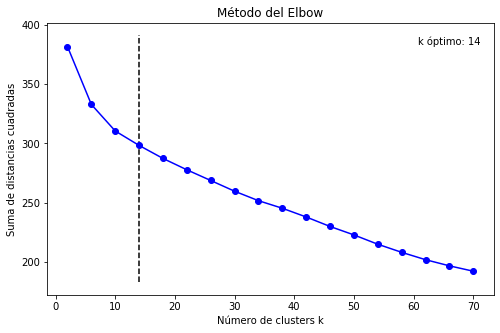

Wall time: 11.7 s


In [17]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

In [18]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=14
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se chequea falla no detectando problema aparente surtidores operando normal se chequea falla no detectando problema aparente surtidores operando normal
	sentence  0 :  se chequea falla y se realiza reset a surtidor encore 500s se prueba quwdando operativo en un 100 se chequea falla y se realiza reset a surtidor encore 500s se prueba quwdando operativo en un 100
	sentence  1 :  se rev surtidor de kerosene el cual mantenia automatico caido se activa y queda funcionando se espera ver expendio el cual mantiene normal se rev surtidor de kerosene el cual mantenia automatico caido se activa y queda funcionando se espera ver expendio el cual mantiene normal
	sentence  2 :  en surtidor numero 7 kerosenne se detecto y se cambio 01 swivels de 34 con filtracion se realizan pruebas con ven tas quedando boca operativa en surtidor numero 7 kerosenne se detecto y se cambio 01 swivels de 34 con filtracion se realizan pruebas con ven tas quedando boca operativa
	sentence  3 :  se 

In [19]:
# Clusters representativos (con n = 14)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se chequea falla no detectando problema aparente surtidores operando normal se chequea falla no detectando problema aparente surtidores operando normal
Cluster  1 : ods mal emitida
Cluster  2 : se realiza mantencion preventiva a lados 1 al 6 se realiza verificacion volumetrica con matraz de 20 litros a 32 bocas de 32 se revisan interior de equipos se revisan y prueban accesorios se cambia wipehose de diesel lado 4 roto por desgaste de mategial en el tiempo se revisan y limpian spill descargas se pintan tapas de descargas quedan todos los equipos operativos se realiza mantencion preventiva a lados 1 al 6 se realiza verificacion volumetrica con matraz de 20 litros a 32 bocas de 32 se revisan interior de equipos se revisan y prueban accesorios se cambia wipehose de diesel lado 4 roto por desgaste de mategial en el tiempo se revisan y limpian spill descargas se pintan tapas de descargas quedan todos los equipos operativos
Cluster  3 : se chequea falla realizando prueba de pres

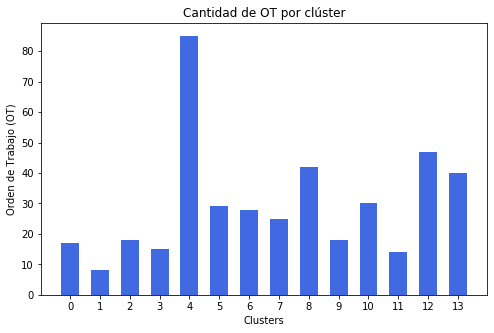

In [20]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = False) 

## 3. TÉCNICOS ASIGNADOS

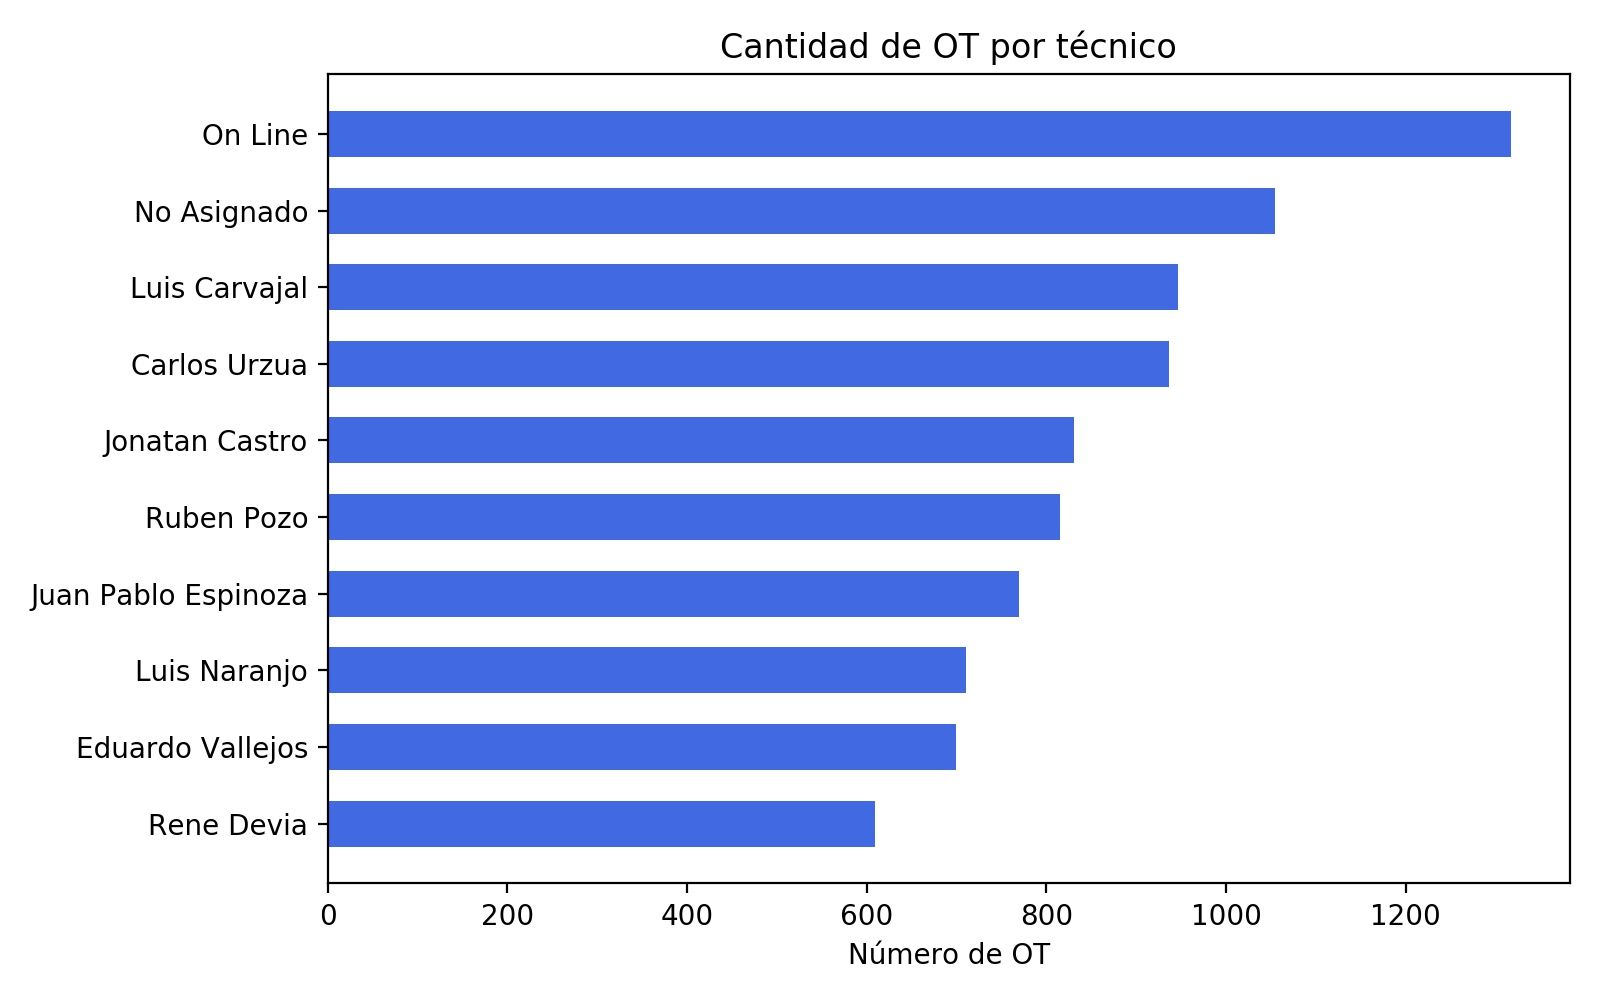

In [21]:
from IPython.display import Image
Image(filename='../1. OGC - Análisis y limpieza BD/4) Tecnico asignado.jpg',width=600, height=400)

In [22]:
# SELECCIONANDO UN TECNICO ASIGNADO ('On Line')
df = df_total[df_total['Tecnico Asignado'] == 'On Line'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

1302

In [23]:
# Extracto obs tecnico
sentences[:2]

['cambio de graficas de equipos no esta contemplado en estaciones delegadas',
 'remplazo de graficas no esta contemplado en estaciones delegadas']

#### Ejecutar el algoritmo para un técnico

Número óptimo de clústers: 22


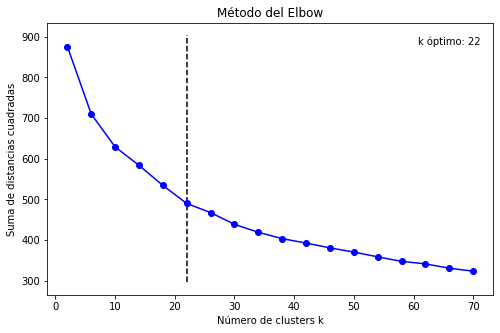

Wall time: 15.4 s


In [24]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

In [25]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : ods mal ingresado
	sentence  0 :  os mal ingresada
	sentence  1 :  os mal ingresada
	sentence  2 :  mal ingresada
	sentence  3 :  ods mal ingresado
	sentence  4 :  os mal ingresada
	sentence  5 :  ods mal ingresada
	sentence  6 :  ods mal ingresada
	sentence  7 :  mal ingresada
	sentence  8 :  ods mal ingresada
	sentence  9 :  ods mal ingresada
	sentence  10 :  mal ingresada
	sentence  11 :  mal ingresada
	sentence  12 :  ods mal ingresada
	sentence  13 :  mal ingresada
	sentence  14 :  mal ingresada
	sentence  15 :  ods mal ingresada
	sentence  16 :  mal ingresada
	sentence  17 :  ods mal ingresada
	sentence  18 :  ods mal ingresada
	sentence  19 :  mal ingresada
	sentence  20 :  ods mal ingresada
Cluster 1 : ods mal emitida
	sentence  0 :  ods mal emitida
	sentence  1 :  ods mal emitida
	sentence  2 :  ods mal emitida
	sentence  3 :  ods mal emitida
	sentence  4 :  ods mal emitida
	sentence  5 :  ods mal emitida
	sentence  6 :  ods mal emitida
	sentence  7 :  o

	sentence  34 :  os mal emitida
	sentence  35 :  os mal emitida
	sentence  36 :  os mal emitida
	sentence  37 :  os mal emitida
	sentence  38 :  os mal emitida
	sentence  39 :  os mal emitida
	sentence  40 :  os mal emitida
	sentence  41 :  os mal emitida
	sentence  42 :  os mal emitida
	sentence  43 :  os mal emitida
	sentence  44 :  os mal emitida
	sentence  45 :  os mal emitida
	sentence  46 :  os mal emitida
	sentence  47 :  os mal emitida
	sentence  48 :  os mal emitida
	sentence  49 :  os mal emitida
	sentence  50 :  os mal emitida
	sentence  51 :  os mal emitida
	sentence  52 :  os mal emitida
	sentence  53 :  os mal emitida
	sentence  54 :  os mal emitida
	sentence  55 :  os mal emitida
	sentence  56 :  os mal emitida
	sentence  57 :  os mal emitida
	sentence  58 :  os mal emitida
	sentence  59 :  os mal emitida
	sentence  60 :  os mal emitida
	sentence  61 :  os mal emitida
	sentence  62 :  os mal emitida
	sentence  63 :  os mal emitida
	sentence  64 :  os mal emitida
	sentenc

	sentence  161 :  incidencia es cerrada ya que en pi se esta realizando cambio de equipo por otro mantenedor
	sentence  162 :  se realiza el cambio de 1 filtro baja capacidad quedando equipo operativo
	sentence  163 :  se realiza el cambio de 1 teclado predeterminador equipo 2v p14911 quedando equipo operativo
	sentence  164 :  por solicitud de rodrigo delgado se descarta la orden de trabajo
	sentence  165 :  por solicitud de rodrigo delgado se descarta la orden de trabajo
	sentence  166 :  se envia guia informativa para cambio de hora en veeder root a
	sentence  167 :  se envia documento guia para cambio de hora en veeder root para que la administracion de estacion de servicio pueda realizar el cambio de horario sin dificultad
	sentence  168 :  segun lo conversado con don rodrigo delgado se envio documento guia para cambio de hora en equipo veeder root tls350 para que la estacion de servicio pueda realizar el cambio de horario en el veeder root
	sentence  169 :  incidencia es cerrada 

In [26]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : ods mal ingresado
Cluster  1 : ods mal emitida
Cluster  2 : incidencia atendida bajo ot 3
Cluster  3 : se cierra por error de carga incidencia ya tenia ot
Cluster  4 : se cierra os ya que a partir de que se enlazaron los sistemas de sysqmr y csim se crearon os y ot automaticas duplicando las os de mp
Cluster  5 : ot atendida por otro contratista
Cluster  6 : cliente reasigno incidencia ya que corresponde a otro contratista
Cluster  7 : incidencia mal emitida
Cluster  8 : incidencia no corresponde a sgs por lo tanto se cierra ot
Cluster  9 : incidencia es atendida bajo ot 1
Cluster  10 : incidencia mal asignada
Cluster  11 : incidencia se cierra ya que no corresponde a contrato combustibles
Cluster  12 : incidencia se cierra en mp ot 26867
Cluster  13 : se envia informe a petrobras por variaciones en eds
Cluster  14 : ot periodo vencido incidencia atendida bajo ot 20175
Cluster  15 : incidencia es atendida bajo ot 5
Cluster  16 : incidencia duplicada
Cluster  17 : incidenci

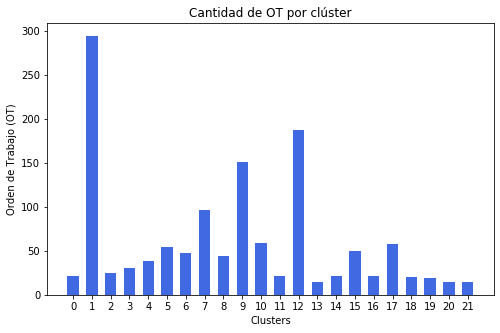

In [27]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = False) 

## 4. PRIORIDAD

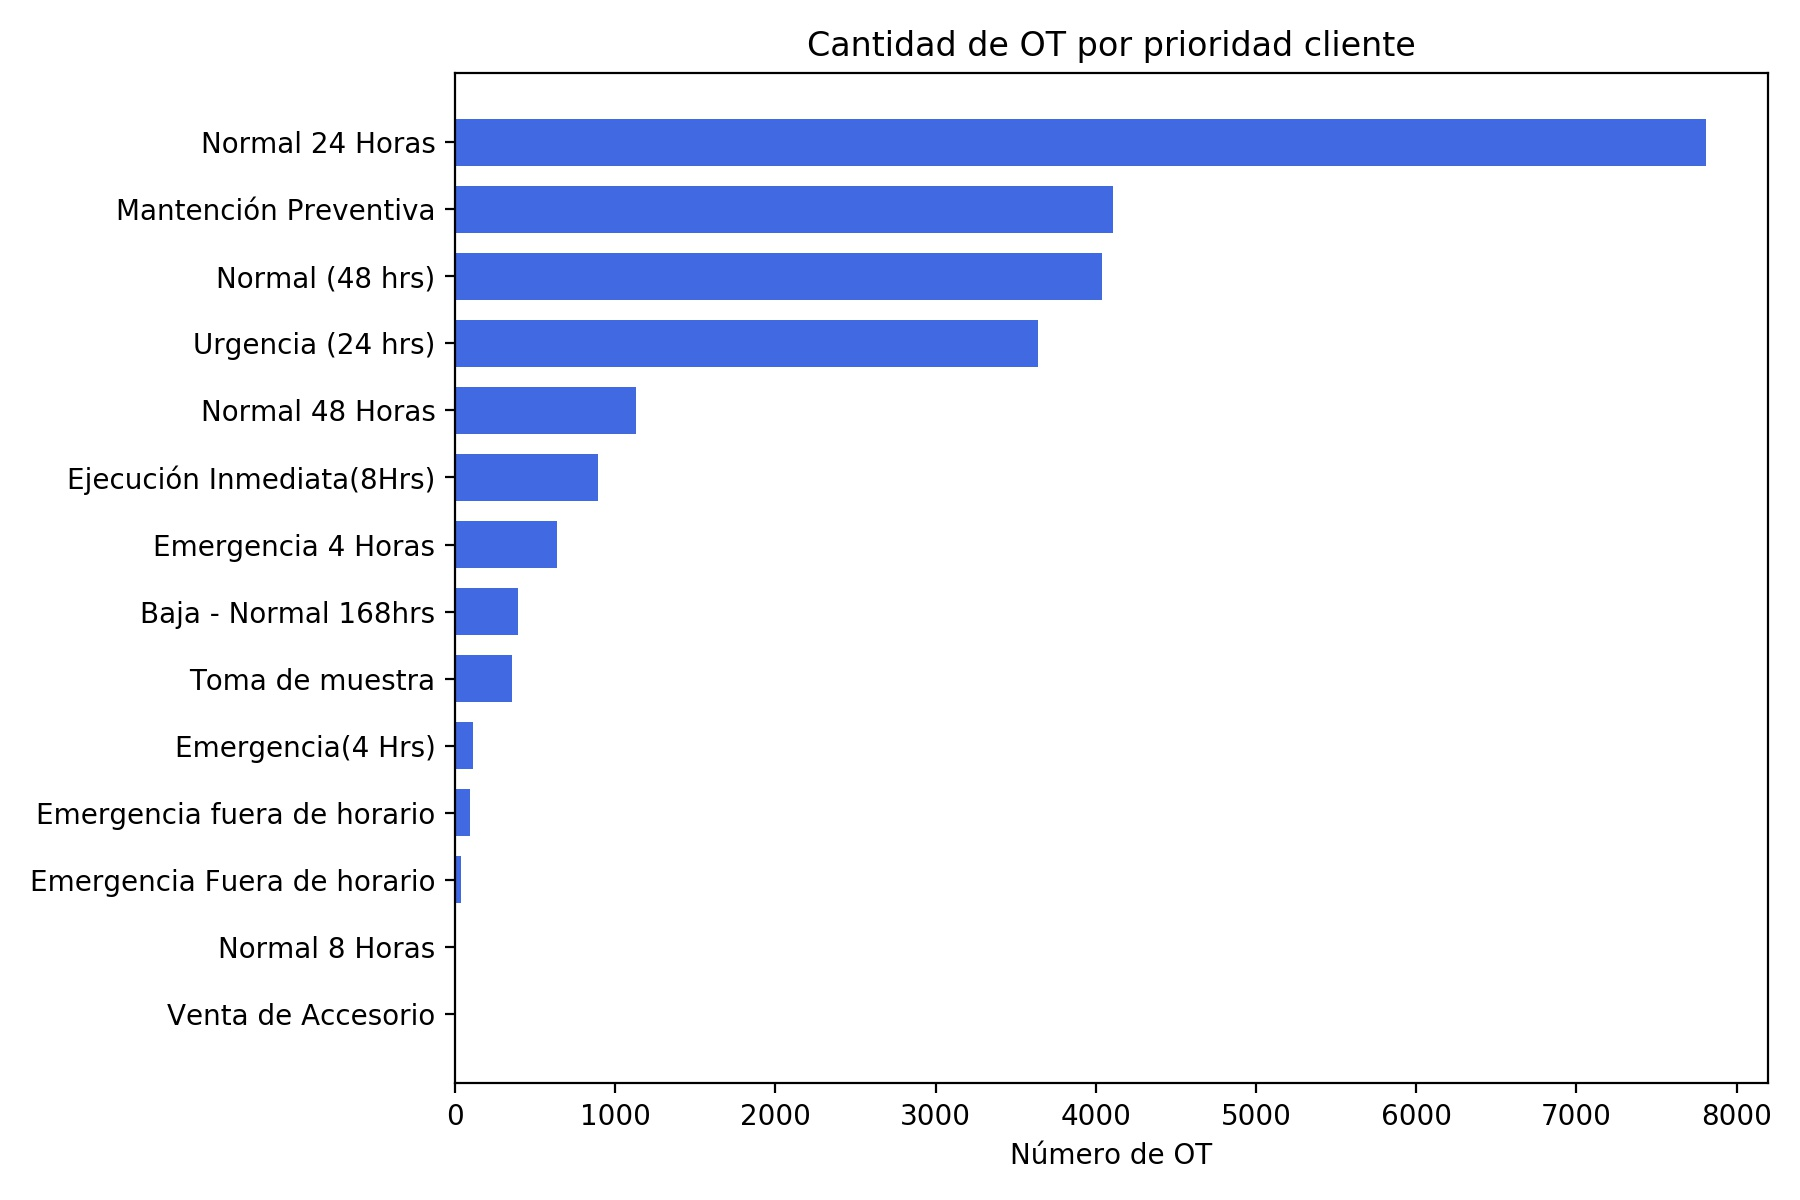

In [28]:
from IPython.display import Image
Image(filename='../1. OGC - Análisis y limpieza BD/6) Prioriad cliente.jpg',width=600, height=500)

In [29]:
# SELECCIONANDO UNA PRIORIDAD ('Emergencia 4 Horas')
df = df_total[df_total['Prioridad Cliente'] == 'Emergencia 4 Horas'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

632

In [30]:
# Extracto obs prioridad
sentences[:2]

['se realiza mantencion correctiva en surtidor lado 5 el cual presentaba problemas en pistola la cual no despachada combustible se procede a cambiar accsesorio quedando en optimas condiciones de funcionamiento se realiza mantencion correctiva en surtidor lado 5 el cual presentaba problemas en pistola la cual no despachada combustible se procede a cambiar accsesorio quedando en optimas condiciones de funcionamiento',
 'en dispensador numero 1 se detecto y se cambio 01 pistola convencional de 1 con cano quebrado se recircula producto con ventas quedando operativa repuesto utilizado 01 pistola convenc de 1 p14781 en dispensador numero 1 se detecto y se cambio 01 pistola convencional de 1 con cano quebrado se recircula producto con ventas quedando operativa repuesto utilizado 01 pistola convenc de 1 p14781']

#### Ejecutar el algoritmo para una prioridad

Número óptimo de clústers: 30


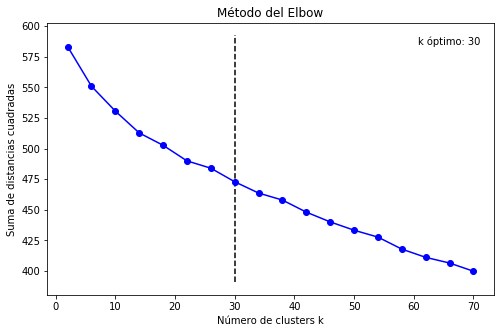

Wall time: 20.4 s


In [31]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

In [32]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=30
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se realiza revision de equipo detectandose falla electrica aguas arriba se informa a cliente para que derive a mantenedor correspondiente para regularizar instalacion electrica
	sentence  0 :  se realiza revision de equipo detectandose falla electrica aguas arriba se informa a cliente para que derive a mantenedor correspondiente para regularizar instalacion electrica
	sentence  1 :  se realiza visita a eds detectandose boton parada de emergencia con fallas se informa a cliente para que derive a mantenedor correspondiente
	sentence  2 :  se realiza revison de equipo y tdf detectandose perdida de aislacion se informa a cliente para derivar a mantenedor correspondiente y regularizar a la brevedad
	sentence  3 :  se realiza visita a punto no encontrandose personal que autorice labores se informa a enex y trabajos son derivados a mantenedor electrico por perdida de aislacion en circuito electrico
	sentence  4 :  se realiza regularizacion de rele termico en tdf quedand

	sentence  12 :  queda pendiente cuenta litros para producto adblue se realiza instalacion de cuenta litros digital ad blue piusi quedando operativo
	sentence  13 :  se realiza visita a estacion de servicio encontrando surtidor adblue con filtracion se procede a la reparacion de la filtracion en boca 29 producto adblue quedando boca operativa se recircula producto para prueba de funcionamiento sin presentar filtracion en su despacho se realiza visita a estacion de servicio encontrando surtidor adblue con filtracion se procede a la reparacion de la filtracion en boca 29 producto adblue quedando boca operativa se recircula producto para prueba de funcionamiento sin presentar filtracion en su despacho
Cluster 26 : se verifica equipo observando falla reportada realizando cambio de repuesto que generaba la falla equipo queda operativo se verifica equipo observando falla reportada realizando cambio de repuesto que generaba la falla equipo queda operativo
	sentence  0 :  se visita eds por lla

In [33]:
# Clusters representativos (con n = 30)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se realiza revision de equipo detectandose falla electrica aguas arriba se informa a cliente para que derive a mantenedor correspondiente para regularizar instalacion electrica
Cluster  1 : se realiza cambio de 01 breakaway de 1 en surtidor 1 de diesel quedando operativo se realiza cambio de 01 breakaway de 1 en surtidor 1 de diesel quedando operativo
Cluster  2 : se realiza el cambio de 1 breackaway 1 quedando equipo operativo
Cluster  3 : queda pendiente el cambio de 1 fuente de poder se realiza cambio de fuente de poder quemada a equipo octuple lados 34 por lo que no despachaba productos 9395 y 97 se prueba recirculando litros queda operando normal queda pendiente el cambio de 1 fuente de poder se realiza cambio de fuente de poder quemada a equipo octuple lados 34 por lo que no despachaba productos 9395 y 97 se prueba recirculando litros queda operando normal
Cluster  4 : se realiza el cambio de 2 filtros alta capacidad y 1 pistola 1 quedando equipo operativo
Cluster  5

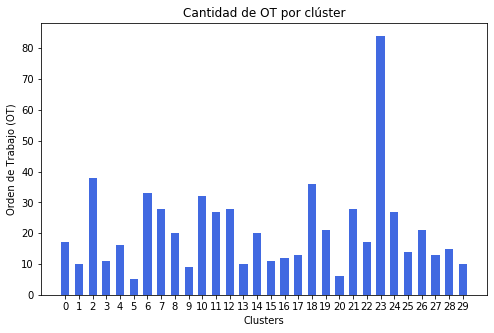

In [34]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = False) 

## 5. ESTADO OT 

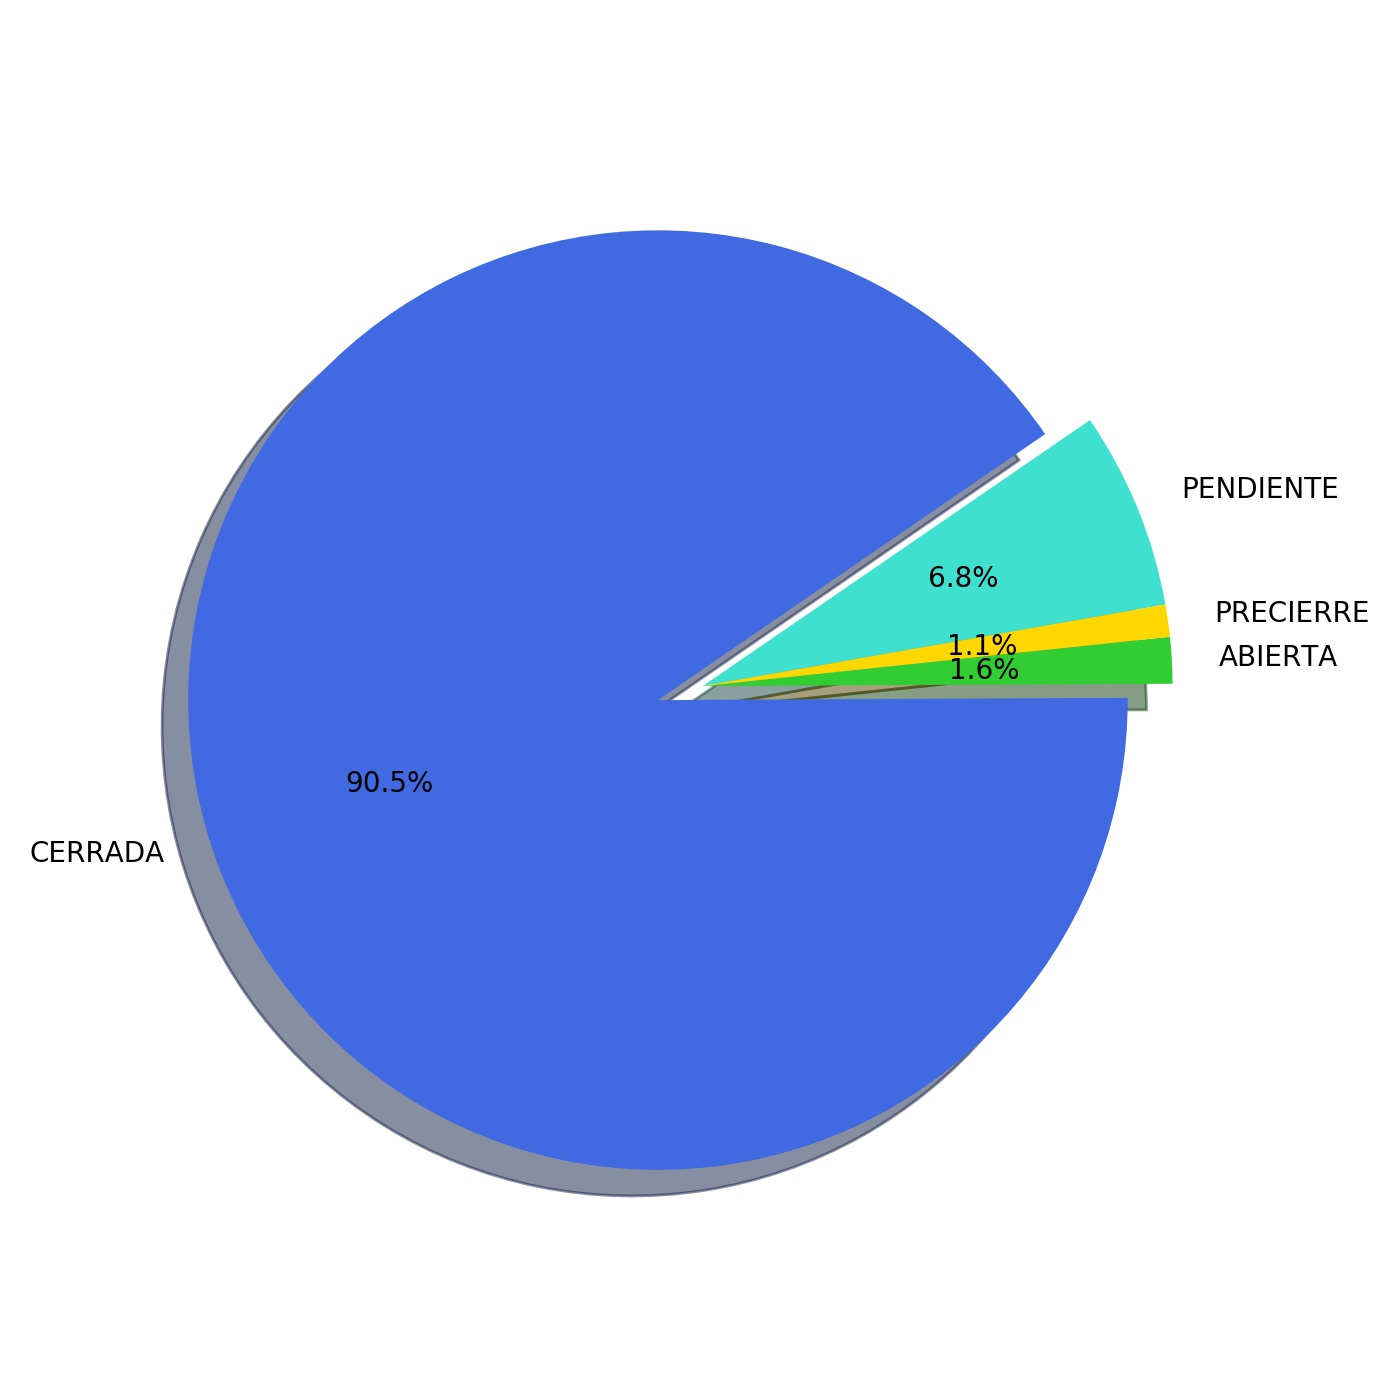

In [35]:
from IPython.display import Image
Image(filename='../1. OGC - Análisis y limpieza BD/5) Estado OT.jpg',width=400, height=400)

In [36]:
# SELECCIONANDO UN ESTADO OT ('PENDIENTE')
df = df_total[df_total['Estado OT'] == 'PENDIENTE'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

1128

In [37]:
# Extracto obs estado ot
sentences[:2]

['kadshjadsjsakjlskjlsajkshshadsdeqwriqweuibuci', 'eds fuera de contrato']

#### Ejecutar el algoritmo para un estado OT

Número óptimo de clústers: 18


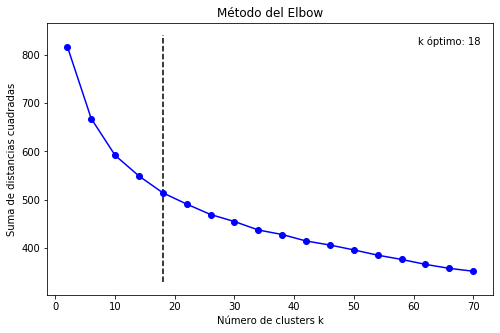

Wall time: 22.5 s


In [38]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

In [39]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=18
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se efectua proceso de mantencion preventiva de estanque y equipo de combustible se detecta boca descalibrada en el cual se procede a calibrar quedando dentro de la tolerancia establecida se pinta tapa spill de descarga boca 1 calibrada boca verificadas 1 de 1 punto industrial queda operativo se efectua proceso de mantencion preventiva de estanque y equipo de combustible se detecta boca descalibrada en el cual se procede a calibrar quedando dentro de la tolerancia establecida se pinta tapa spill de descarga boca 1 calibrada boca verificadas 1 de 1 punto industrial queda operativo
	sentence  0 :  chequeo funcionamiento y verificacion volumetrica a 1 surtidor 8 bocas de 8 limpieza y pintado spill cambio de 2 adaptadores de descarga en tk nro 2 gas 97 y tk nro 3 gas 93 ambas con trizaduras chequeo funcionamiento y verificacion volumetrica a 1 surtidor 8 bocas de 8 limpieza y pintado spill cambio de 2 adaptadores de descarga en tk nro 2 gas 97 y tk nro 3 gas 93 ambas 

	sentence  1 :  se calibran 24 de 25 sin kerosene se realiza mantencion preventiva a lados 1 al 6 se realiza verificacion volumetrica con matraz de 20 litros a 24 bocas de 25 se revisan interior de equipos se revisan y prueban accesorios se revisan y limpian spill descargas quedan todos los equipos operativos se calibran 24 de 25 sin kerosene se realiza mantencion preventiva a lados 1 al 6 se realiza verificacion volumetrica con matraz de 20 litros a 24 bocas de 25 se revisan interior de equipos se revisan y prueban accesorios se revisan y limpian spill descargas quedan todos los equipos operativos
	sentence  2 :  se realiza mantencion preventiva se calibran 23 de 23 se realiza mantencion preventiva a lados 1 al 7 se realiza verificacion volumetrica con matraz de 20 litros a 21 bocas de 23 bocas 20 y 21 se encuentran sin colgantes por perro muerto se revisan interior de equipos y se limpian se revisan y prueban accesorios se revisan y limpian spill descargas quedan operativos todos los

	sentence  32 :  se realiza calibracion a 01 surtidor el cual se encuentra dentro rango permitido chequeo accesorios colgantes y limpieza se realiza calibracion a 01 surtidor el cual se encuentra dentro rango permitido chequeo accesorios colgantes y limpieza
	sentence  33 :  se realiza calibracion 02 bocas diesel se realiza limpieza interna y externa de surtidor y elementos colgantes se realiza inspeccion general de surtidor sump dispenser spill tablero electrico etc surtidor se encuentra operativo y calibrado dentro de la norma se realiza calibracion 02 bocas diesel se realiza limpieza interna y externa de surtidor y elementos colgantes se realiza inspeccion general de surtidor sump dispenser spill tablero electrico etc surtidor se encuentra operativo y calibrado dentro de la norma
Cluster 15 : se realiza mantencion preventiva se calibran 2 bocas
	sentence  0 :  se realiza mantencion preventiva se calibran 2 bocas de 2
	sentence  1 :  mantencion preventiva se calibran 2 de 2
	sentence

In [40]:
# Clusters representativos (con n = 18)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se efectua proceso de mantencion preventiva de estanque y equipo de combustible se detecta boca descalibrada en el cual se procede a calibrar quedando dentro de la tolerancia establecida se pinta tapa spill de descarga boca 1 calibrada boca verificadas 1 de 1 punto industrial queda operativo se efectua proceso de mantencion preventiva de estanque y equipo de combustible se detecta boca descalibrada en el cual se procede a calibrar quedando dentro de la tolerancia establecida se pinta tapa spill de descarga boca 1 calibrada boca verificadas 1 de 1 punto industrial queda operativo
Cluster  1 : ods mal emitida
Cluster  2 : se realiza mantencion preventiva se calibran 1 boca
Cluster  3 : mantencion preventiva se calibran 17 de 18 no se calibra 1 boca de kero por encontrase fuera de servicio queda pendiente realizar mantenimiento preventivo ya que estacion de servicio se encuentra con problemas de orpak se realiza mantenimiento preventivo se calibran 16 bocas en total no se cal

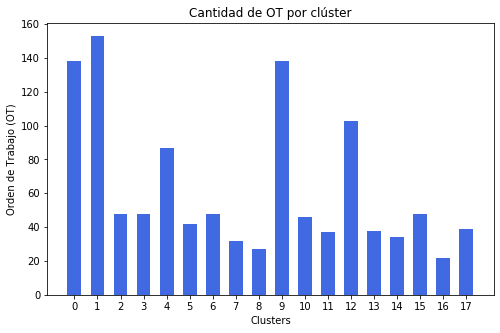

In [41]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = False) 

# TESTS 

## Prueba con el dataset de sentences más largo (cerca de 10.000) - Tipo de falla

In [42]:
# SELECCIONANDO UN TIPO DE FALLA EN PARTICULAR 
df = df_total[df_total['Tipo de Falla'] == 'Carrete RetractilOTROOTRO'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

9324

Número óptimo de clústers: 26


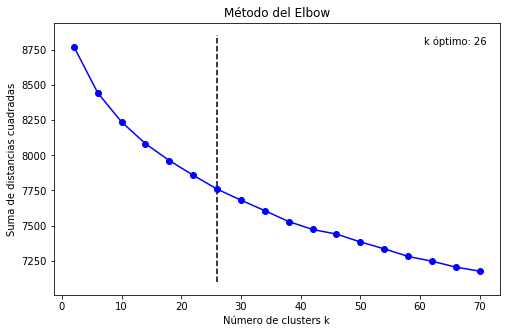

Wall time: 9min 46s


In [43]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

In [44]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=26
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : programa mantencion preventiva mes junio 2019 mp calibracion verificacion detector de fuga chequeo de calibracion y mantencion de los dispensadores n 12 34 limpieza interna y externa de equipos cambio de filtros para diesel gas 93 y gas 97 en los dispensadores no12 y 34 cambio de 01 breakaway 34 en la boca de diesel del dispensador n 2 el cual presenta filtracion se debe volver a estacion de servicio para continuar con mantencion preventiva reparacion de filtracion en medidor de diesel del dispensador n 3 se cambian 04 empaquetaduras de corcho codigo de repuesto compra en plaza cambio de filtros para gas 93 gas 97 y diesel en el dispensador n 56 chequeo de calibracion y mantencion de los dispensadores n 56 y 78 limpieza interna y externa de equipos se aplica pintura e identificacion de tapas spill contaiment se realizan pruebas de operatividad de detectores de fugas electronicos para gas 93 gas97 diesel y kerosene los cuales se encuentran operativos equipos queda

	sentence  246 :  queda pendiente tapa manhole boss p 15211 en tk v power es reemplazada 01 tapa monhole 12 en tk v power quedando operativo queda pendiente tapa manhole boss p 15211 en tk v power es reemplazada 01 tapa monhole 12 en tk v power quedando operativo
	sentence  247 :  se realiza cambio de tapa adaptadore de descarga de 4 pulgada en tk 2 de 93 tk 4 de 97 y tk 5 diesel se deja operativo codigo tapa adaptadora p16264 fueron 3 tapas se realiza cambio de tapa adaptadore de descarga de 4 pulgada en tk 2 de 93 tk 4 de 97 y tk 5 diesel se deja operativo codigo tapa adaptadora p16264 fueron 3 tapas
	sentence  248 :  son reemplazadas 02 tapas de adaptador 4 por estar quebradas en tk 93 y tk diesel son reemplazadas 02 tapas de adaptador 4 por estar quebradas en tk 93 y tk diesel
	sentence  249 :  en cano descarga de diesel es reemplazado adaptador de 4 mas su tapa 4 de copec a shell quedando descarga operativa en cano descarga de diesel es reemplazado adaptador de 4 mas su tapa 4 de 

	sentence  86 :  se observa flujo lento en producto 93 y 95 en 02 equipos b7c encontrandose filtros saturados producto 93 equipo mezclador se requiere cambio se comunica a encargada equipos corta antes de venta programada se observa flujo lento en producto 93 y 95 en 02 equipos b7c encontrandose filtros saturados producto 93 equipo mezclador se requiere cambio se comunica a encargada equipos corta antes de venta programada
	sentence  87 :  se realiza el cambio de 2 filtro baja capacidad quedando equipo operativo
	sentence  88 :  se revisa dispensador 8 producto gas 95 encontrandose filtro de gas 97 tapado se le informa a administracion que debe cambiar filtro se revisa dispensador 8 producto gas 95 encontrandose filtro de gas 97 tapado se le informa a administracion que debe cambiar filtro
	sentence  89 :  se realiza el cambio de 1 filtro ac en disp 78 93 por estar lento quedando ok se realiza el cambio de 1 filtro ac en disp 78 93 por estar lento quedando ok
	sentence  90 :  revision 

	sentence  227 :  se realiza limpieza y mantencion a valvula check de estanque 3 de producto 93 la cual presentaba caida de presion constantemente queda operativa visita en conjunto con gilbarco para la inicializacion de dispensador numero 34 queda operativa se realiza limpieza y mantencion a valvula check de estanque 3 de producto 93 la cual presentaba caida de presion constantemente queda operativa visita en conjunto con gilbarco para la inicializacion de dispensador numero 34 queda operativa
	sentence  228 :  se chequea venta con clientes bomba funciona normal no arrojando alarma en vedeeroot se guarda balde vacio en camioneta se realiza limpieza de camara que recepciona valvula check en bomba de gas97 y ademas se ajusta tornillo de presion en bomba equipo queda operativo
	sentence  229 :  se visita eds para realizar chequeo de by pass entre tk 4 y 5 de gasolina 93 lo cual se encuentra con valvula de sifon en mal estado por lo tanto se solicita 01 valvula de sifon para cabezal de bo

	sentence  235 :  se realiza verificacion de nivel de agua en tk pd detectando 28 cm de agua se coordinara extraccion ya que eds no cuenta con tambor para el retiro de esta agua se toma contacto telefonico con el sr ivan castro para coordinar extraccion de agua la cual se habia revisado en visita anterior y la eds no contaba con tambor cerrado el dia de hoy de se procede a cerrar la solicitud ya que aun no cuentan con el tambor necesario para el residuo contaminado y encargado generara otra solicitud cuando cuenten con recipiente apropiado para esta extraccion se realiza verificacion de nivel de agua en tk pd detectando 28 cm de agua se coordinara extraccion ya que eds no cuenta con tambor para el retiro de esta agua se toma contacto telefonico con el sr ivan castro para coordinar extraccion de agua la cual se habia revisado en visita anterior y la eds no contaba con tambor cerrado el dia de hoy de se procede a cerrar la solicitud ya que aun no cuentan con el tambor necesario para el r

	sentence  30 :  en pos 3 es reemplazada 01 manguera de 34 por 320 mts por estar perforada por uso en display pos 3 es cambiada 01 ampolleta pls por estar quemada equipo queda operativo en pos 3 es reemplazada 01 manguera de 34 por 320 mts por estar perforada por uso en display pos 3 es cambiada 01 ampolleta pls por estar quemada equipo queda operativo
	sentence  31 :  se revisan displey de dispensador bocas 25 y 26 de kerosene encontrando 8 tarjetas backlight con ampolletas quemadas se solicitan tarjetas para reemplazo back light entregados en bp para su reparacion cambio de 8 tarjetas backlight a dispensador 7 y 8 de kerosene por tener ampolletas quemadas equipo queda operativo nota tarjetas backlight 3 ampolletas reparadas en banco de pruebas se revisan displey de dispensador bocas 25 y 26 de kerosene encontrando 8 tarjetas backlight con ampolletas quemadas se solicitan tarjetas para reemplazo back light entregados en bp para su reparacion cambio de 8 tarjetas backlight a dispensado

	sentence  86 :  se realiza chequeo en consola veeder root 350 alarma l5 se realiza retiro de sensor discriminador de isla n7 y se procede a recuperacion de este se procede a instalar nuevamente eliminando alarma en consola quedando operativo se realiza chequeo a equipo dispensador n3 y n4 gasolinas detectando flujo lento por filtros saturados estacion es delegada equipo operativo se recomienda a administracion realizar cambio de filtros a equipo se realiza chequeo en consola veeder root 350 alarma l5 se realiza retiro de sensor discriminador de isla n7 y se procede a recuperacion de este se procede a instalar nuevamente eliminando alarma en consola quedando operativo se realiza chequeo a equipo dispensador n3 y n4 gasolinas detectando flujo lento por filtros saturados estacion es delegada equipo operativo se recomienda a administracion realizar cambio de filtros a equipo
	sentence  87 :  se chequean alarmas l5 y l11 correspondientes a tamk sump diesel y tamk sump kerosene se recuperan

	sentence  25 :  se realiza cambio de un breakaway reconectable rv lado 1 gas97 por filtracion malo por uso se recirculan litros para prueba queda operando normalmente se realiza cambio de un breakaway reconectable rv lado 1 gas97 por filtracion malo por uso se recirculan litros para prueba queda operando normalmente
	sentence  26 :  se guarda balde vacio en camioneta se realiza cambio de breakaway 34 reconectable por rotura del anterior el cual era convencional se recircula producto quedando equipo operativo
	sentence  27 :  se realiza el cambio de 1 breakaway vr p16674 en dispensador numero 7 quedando operativo se realiza el cambio de 1 breakaway vr p16674 en dispensador numero 7 quedando operativo
	sentence  28 :  se realiza el cambio de 1 breakaway rv y 1 manguera rv en disp 5 93 por estar filtrando quedando operativo se realiza el cambio de 1 breakaway rv y 1 manguera rv en disp 5 93 por estar filtrando quedando operativo
	sentence  29 :  se realiza cambio de breakaway cortado de 

	sentence  247 :  incidencia atendida bajo ot 3
	sentence  248 :  se debe efectuar el retiro de 150 lts aprox de agua en el tk n 4 de diesel orden de servicio es atendido bajo el numero de os 101721 ot 24936 se debe efectuar el retiro de 150 lts aprox de agua en el tk n 4 de diesel orden de servicio es atendido bajo el numero de os 101721 ot 24936
	sentence  249 :  incidencia fue atendida bajo la ot 23335
	sentence  250 :  incidencia esta siendo atendida bajo la ot 1
	sentence  251 :  os y es atendida bajo os 100168 y ot 3 os y es atendida bajo os 100168 y ot 3
	sentence  252 :  se llega a intalacion no se encuentran encargados personal presente desconoce solicitud y no pueden autorizar trabajosincidencia atendida bajo la ot 6
	sentence  253 :  os es cerrada bajo os 99865 ot 1 os es cerrada bajo os 99865 ot 1
	sentence  254 :  incidencia atendida inciden ia certada bajo ot del dia 24 de mayo del 2019 con cabio de medidor trabado
	sentence  255 :  servicio atendido bajo la orden n 9 ser

	sentence  118 :  swivel cumple vida util cambio de swivel 1 a boca 26 de pd alto flujo el cual se cesvoco y filtra combustible
	sentence  119 :  cambio de manguera rota a boca n 1 de p diesel uso cambio de pistola a boca n 1 de p diesel por botar producto sin precionar gatillo vida util equipo queda operativo cambio de manguera rota a boca n 1 de p diesel uso cambio de pistola a boca n 1 de p diesel por botar producto sin precionar gatillo vida util equipo queda operativo
	sentence  120 :  boca 2 no se calibra fuera de servicio por encargado de file 93121 se ocupa repuesto el cual no esta em stock en mi bodega codigo p14776 pistola 34 black mantencion preventiva calibracion volumetrica surtidor snlid1121sh serie 615482 recirculacion producto diesel cambio pistola 34 en boca 1 la cual no corta al despachar producto chequeo de fugas y flujo inspeccion general pintura visble tk 1 matencion balde antiderrame tk 1 y valvula boca numero 2 fuera de servicio por encargado de file esta no se c

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [45]:
# Clusters representativos (con n = 26)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : programa mantencion preventiva mes junio 2019 mp calibracion verificacion detector de fuga chequeo de calibracion y mantencion de los dispensadores n 12 34 limpieza interna y externa de equipos cambio de filtros para diesel gas 93 y gas 97 en los dispensadores no12 y 34 cambio de 01 breakaway 34 en la boca de diesel del dispensador n 2 el cual presenta filtracion se debe volver a estacion de servicio para continuar con mantencion preventiva reparacion de filtracion en medidor de diesel del dispensador n 3 se cambian 04 empaquetaduras de corcho codigo de repuesto compra en plaza cambio de filtros para gas 93 gas 97 y diesel en el dispensador n 56 chequeo de calibracion y mantencion de los dispensadores n 56 y 78 limpieza interna y externa de equipos se aplica pintura e identificacion de tapas spill contaiment se realizan pruebas de operatividad de detectores de fugas electronicos para gas 93 gas97 diesel y kerosene los cuales se encuentran operativos equipos quedan operativ

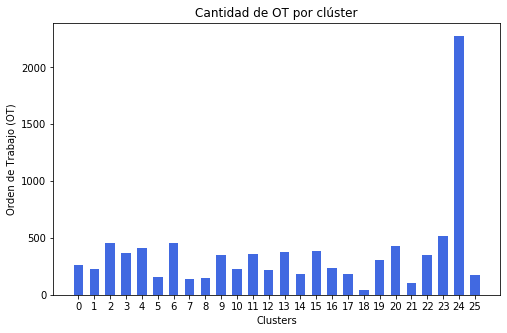

In [46]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = False) 

## Más pruebas con estaciones

### Estación con más de 100 sentences 

In [47]:
# SELECCIONANDO UNA ESTACIÓN ('Inversiones Enex')
df = df_total[df_total['Estacion'] == 'Inversiones Enex'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

195

Número óptimo de clústers: 22


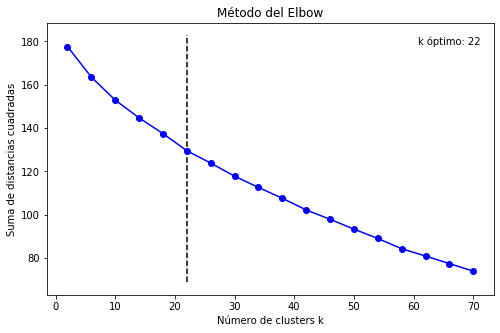

Wall time: 7.17 s


In [48]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

In [49]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se realiza el cambio de 01 pistola 7h 1 pulgada en la boca 2 pd por presentar filtraciones en base del cano queda operativo se realiza el cambio de 01 pistola 7h 1 pulgada en la boca 2 pd por presentar filtraciones en base del cano queda operativo
	sentence  0 :  se realiza el cambio de 01 pistola de 1 pulg en la boca 35 pd por encontrarse con varias filtraciones se retira pistola opw sn 17185 y se instala pistola opw sn 181284 se verifico funcionamiento con venta quedando operativo se realiza el cambio de 01 pistola de 1 pulg en la boca 35 pd por encontrarse con varias filtraciones se retira pistola opw sn 17185 y se instala pistola opw sn 181284 se verifico funcionamiento con venta quedando operativo
	sentence  1 :  se realiza revision de boca 33 pd isla 10 por encontrarse sin despacho se detecta falla mecanica interna de la pistola lo cual no permite iniciar el despacho se realiza el cambio de la pistola 7h se retira pistola con sn 831361 y se instala 01 pisto

In [50]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se realiza el cambio de 01 pistola 7h 1 pulgada en la boca 2 pd por presentar filtraciones en base del cano queda operativo se realiza el cambio de 01 pistola 7h 1 pulgada en la boca 2 pd por presentar filtraciones en base del cano queda operativo
Cluster  1 : cambio oring 12 opw tk4 por encontrarse partido instalacion oring 12 opw tk2 por ausencia cambio de 02 filtros baja capacidad cambio 01 funda 1 negra por encontrarse rota cambio 01 pistola 1 por falla en corte automatico serie 90004 en disp1 cambio de 03 filtros alta capacidad cambio 02 fundas negras 12 por encontrarse rotas cambio de 03 filtros alta capacidad 02 fundas verdes 01 funda roja 01 acoplamiento fusible seguridad por encontrarse con enganche fracturado chequeo y calibracion disp 1 2 y 3 cambio de 01 funda 12 negra disp3 cambio 02 filtros alta capacidad 01 funda 12 negra 01 funda verde y 01 wipehose 34 por poseer malla metalica expuesta en disp4 cambio 02 filtros baja capacidad y 01 funda negra 1 disp5 cheq

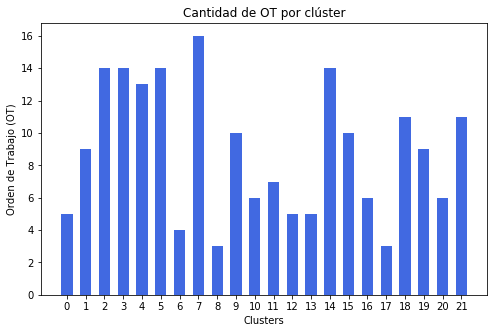

In [51]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = False) 

### Estación con un número de senteces entre 30 y 70

In [52]:
# SELECCIONANDO UNA ESTACIÓN ('LLANOS Y WAMMES SOCIEDAD COMERCIAL LTDA.')
df = df_total[df_total['Estacion'] == 'LLANOS Y WAMMES SOCIEDAD COMERCIAL LTDA.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

52

Número óptimo de clústers: 24


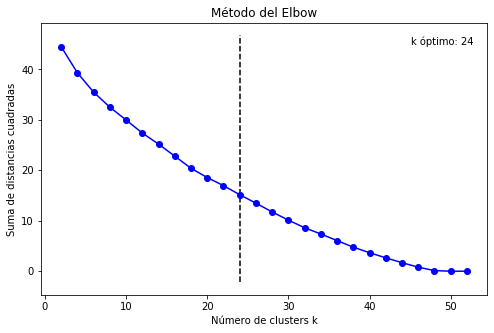

Wall time: 8.71 s


In [53]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

In [54]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=24
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se realiza visita a estacion encontrando todo funcionando se consulta con encargado quien manifiesta que ya habia avisado a su jefe de zona para anular la orden se realiza visita a estacion encontrando todo funcionando se consulta con encargado quien manifiesta que ya habia avisado a su jefe de zona para anular la orden
	sentence  0 :  se realiza visita a estacion encontrando todo funcionando se consulta con encargado quien manifiesta que ya habia avisado a su jefe de zona para anular la orden se realiza visita a estacion encontrando todo funcionando se consulta con encargado quien manifiesta que ya habia avisado a su jefe de zona para anular la orden
Cluster 1 : se realiza visita a estacion de servicio encontrando dispensador alto galonaje bloqueado se procede a reiniciar dispensador y a efectuar chequeo interno en donde se observa conexiones de pulser con presencia de sulfato se procede a la limpieza y a la reconexion de este dispensador queda operativo se prue

In [55]:
# Clusters representativos (con n = 24)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se realiza visita a estacion encontrando todo funcionando se consulta con encargado quien manifiesta que ya habia avisado a su jefe de zona para anular la orden se realiza visita a estacion encontrando todo funcionando se consulta con encargado quien manifiesta que ya habia avisado a su jefe de zona para anular la orden
Cluster  1 : se realiza visita a estacion de servicio encontrando dispensador alto galonaje bloqueado se procede a reiniciar dispensador y a efectuar chequeo interno en donde se observa conexiones de pulser con presencia de sulfato se procede a la limpieza y a la reconexion de este dispensador queda operativo se prueba con venta a clientes y en presencia de encargado sin presentar problemas en su despacho se realiza visita a estacion de servicio encontrando dispensador alto galonaje bloqueado se procede a reiniciar dispensador y a efectuar chequeo interno en donde se observa conexiones de pulser con presencia de sulfato se procede a la limpieza y a la recon

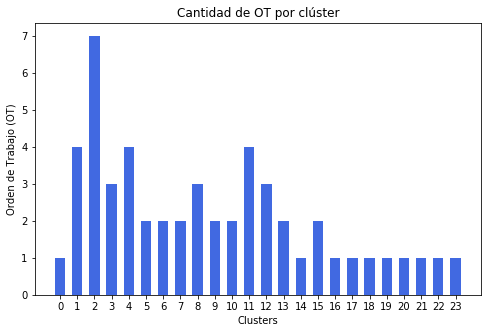

In [56]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = False) 

### Estación con menos de 30 sentences

In [57]:
# SELECCIONANDO UNA ESTACIÓN ('Sociedad Comercial Fariña Y Cia. Ltda.')
df = df_total[df_total['Estacion'] == 'Sociedad Comercial Fariña Y Cia. Ltda.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

16

Número óptimo de clústers: 7


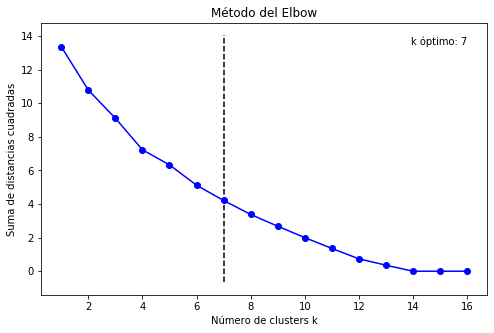

Wall time: 3.27 s


In [58]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

In [59]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=7
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : no se puede cambiar detector de fuga ya que el unico equipo que tienen se encuentra fuera de servicio hace anos y ademas no cuenta con combustible en estanque kerosene no se puede cambiar detector de fuga ya que el unico equipo que tienen se encuentra fuera de servicio hace anos y ademas no cuenta con combustible en estanque kerosene
	sentence  0 :  no se puede cambiar detector de fuga ya que el unico equipo que tienen se encuentra fuera de servicio hace anos y ademas no cuenta con combustible en estanque kerosene no se puede cambiar detector de fuga ya que el unico equipo que tienen se encuentra fuera de servicio hace anos y ademas no cuenta con combustible en estanque kerosene
Cluster 1 : incidencia es atendida bajo ot 1
	sentence  0 :  incidencia es realizada bajo os numero 105957 y ot numero 0 incidencia es realizada bajo os numero 105957 y ot numero 0
	sentence  1 :  incidencia es realizada bajo os numero 105957 y ot numero 0 incidencia es realizada bajo os 

In [60]:
# Clusters representativos (con n = 7)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : no se puede cambiar detector de fuga ya que el unico equipo que tienen se encuentra fuera de servicio hace anos y ademas no cuenta con combustible en estanque kerosene no se puede cambiar detector de fuga ya que el unico equipo que tienen se encuentra fuera de servicio hace anos y ademas no cuenta con combustible en estanque kerosene
Cluster  1 : incidencia es atendida bajo ot 1
Cluster  2 : se realiza mantenimiento preventivo en eds se calibran 16 bocas en total se revisan y limpian equipos se cambia 1 filtro obstruido en post 34 g97 producto recirculado devuelto a tk correspondiente equipos quedan operativos se chequea tdf y tks eds queda totalmente operativa se realiza mantenimiento preventivo en eds se calibran 16 bocas en total se revisan y limpian equipos se cambia 1 filtro obstruido en post 34 g97 producto recirculado devuelto a tk correspondiente equipos quedan operativos se chequea tdf y tks eds queda totalmente operativa
Cluster  3 : se realiza el cambio de 1 swi

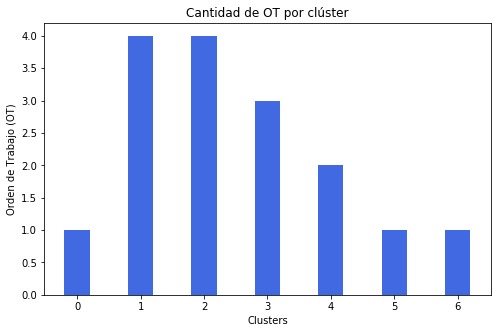

In [61]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters,width=0.4, save = False) 

### En el caso que tenga solo 2 sentences

In [62]:
# SELECCIONANDO UNA ESTACIÓN ('GEOTERMICA DEL NORTE S.A')
df = df_total[df_total['Estacion'] == 'GEOTERMICA DEL NORTE S.A'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

2

Número óptimo de clústers: None


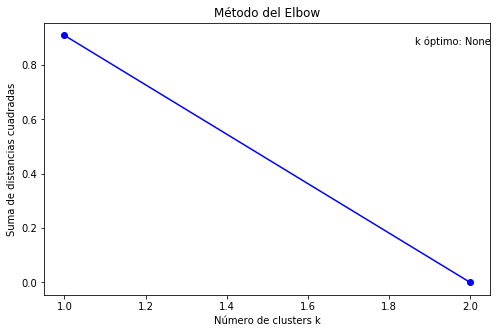

Wall time: 630 ms


In [63]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

### En el caso que tenga solo 1 sentence

In [64]:
# SELECCIONANDO UNA ESTACIÓN ('Santa Laura - San Bernardo')
df = df_total[df_total['Estacion'] == 'Santa Laura - San Bernardo'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

1

In [65]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

You must enter at least two sentences
Wall time: 504 ms
